<a href="https://www.kaggle.com/code/maimunulkjisan/knowledge-distillation-using-cnn?scriptVersionId=152389634" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Knowledge Distillation (Model Compression)
# Purpose: Thesis 
**Date created:** 11/26/2023<br>

Author Name: Maimunul Karim Jisan (https://github.com/maimunul)<br>
University ID: 201001312<br>
Department: CSE<br>
East Delta University<br>
Chittagong, Bangladesh


## Introduction to Rice Leaf Disease Classification using Knowledge Distillation
The main purpose for this project refers to a set of techniques and methodologies aimed at reducing the size of deep learning models, making them more lightweight and efficient while preserving their predictive performance. This is particularly important for deploying models on resource-constrained environments such as mobile devices, edge devices, or in situations where bandwidth is limited.There are several technique available but we choose **Knowledge Distillation Technique** to reduce large model size.<br>

**Knowledge Distillation:** Training a smaller "student" model to mimic the behavior of a larger "teacher" model. The smaller model tries to reproduce the predictions and uncertainty estimates of the larger model.<br><br>

To evacute **Knowledge Distillation** using **Rice Leaf Disease Dataset** from Mendeley Data. Here dataset contain 5932 images with four different rice leaf disease. For example,

Bacterialblight Disease<br>
Blast Disease<br>
Brownspot Disease<br>
Tungro Disease<br>
The dataset contain Train, Test & Validation Images

**Teacher** Model Accuracy is almost 98% on Test Images<br>
Getting **Studen**t model accuracy is 83% on Test Images<br>
After **Knowledge Distillation** Student model accuracy improve: **94%** & student_loss: **0.1694**

## Introduction to Knowledge Distillation

Knowledge Distillation is a procedure for model
compression, in which a small (student) model is trained to match a large pre-trained
(teacher) model. Knowledge is transferred from the teacher model to the student
by minimizing a loss function, aimed at matching softened teacher logits as well as
ground-truth labels.

The logits are softened by applying a "temperature" scaling function in the softmax,
effectively smoothing out the probability distribution and revealing
inter-class relationships learned by the teacher.

**Reference:**

- [Hinton et al. (2015)](https://arxiv.org/abs/1503.02531)

# Setup

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt 
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Data Acquisation and Augmentation

In [2]:
Input_Image = 256
Channels = 3
batch_size = 32

# Data augmentation for training set
train_data = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

# Training set
train_set = train_data.flow_from_directory(
    "/kaggle/input/rice-leaf-datasettrain-test-and-valid/train",
    target_size=(Input_Image, Input_Image),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True
)

# Validation and test sets
common_data = ImageDataGenerator(rescale=1./255)

test_set = common_data.flow_from_directory(
    "/kaggle/input/rice-leaf-datasettrain-test-and-valid/test",
    target_size=(Input_Image, Input_Image),
    batch_size=batch_size,
    class_mode='categorical'
)

val_set = common_data.flow_from_directory(
    "/kaggle/input/rice-leaf-datasettrain-test-and-valid/val",
    target_size=(Input_Image, Input_Image),
    batch_size=batch_size,
    class_mode='categorical'
)
# Input shape
input_shape = (Input_Image, Input_Image, Channels)

Found 4745 images belonging to 4 classes.
Found 595 images belonging to 4 classes.
Found 592 images belonging to 4 classes.


# **Knowledge Distillation**

In [3]:

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


# Teacher Model Architecture & Train & Plotting Curve & Confusion Metrics

In [4]:
# Create the teacher
teacher = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(16,(3,3),activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32,(3,3),activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(256,activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(4,activation = 'softmax')
], name='teacher')

teacher.summary()


Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0   

In [5]:
# Compile and train the teacher using data generator
teacher.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
teacher_history=teacher.fit(train_set, epochs=10, validation_data=val_set)

Epoch 1/10
149/149 [==============================] - 203s 1s/step - loss: 0.9513 - accuracy: 0.6137 - val_loss: 0.7523 - val_accuracy: 0.7162
Epoch 2/10
149/149 [==============================] - 188s 1s/step - loss: 0.6004 - accuracy: 0.7715 - val_loss: 0.5095 - val_accuracy: 0.8108
Epoch 3/10
149/149 [==============================] - 185s 1s/step - loss: 0.4545 - accuracy: 0.8289 - val_loss: 0.4683 - val_accuracy: 0.8395
Epoch 4/10
149/149 [==============================] - 182s 1s/step - loss: 0.3537 - accuracy: 0.8672 - val_loss: 0.2738 - val_accuracy: 0.9172
Epoch 5/10
149/149 [==============================] - 184s 1s/step - loss: 0.3181 - accuracy: 0.8816 - val_loss: 0.2647 - val_accuracy: 0.9020
Epoch 6/10
149/149 [==============================] - 182s 1s/step - loss: 0.2476 - accuracy: 0.9068 - val_loss: 0.1343 - val_accuracy: 0.9561
Epoch 7/10
149/149 [==============================] - 183s 1s/step - loss: 0.2434 - accuracy: 0.9130 - val_loss: 0.1432 - val_accuracy: 0.9493

In [6]:
teacher.evaluate(test_set)

19/19 [==============================] - 7s 342ms/step - loss: 0.0931 - accuracy: 0.9664


[0.09314631670713425, 0.9663865566253662]

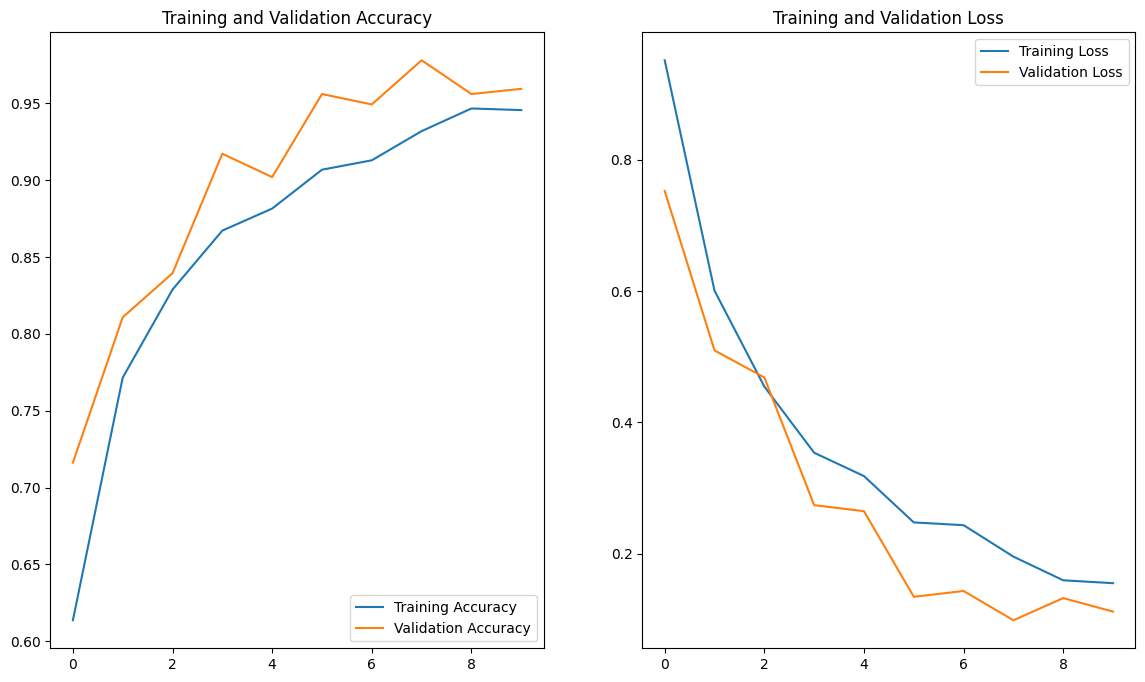

In [7]:
acc = teacher_history.history['accuracy']
val_acc = teacher_history.history['val_accuracy']

loss = teacher_history.history['loss']
val_loss = teacher_history.history['val_loss']
EPOCHS=10
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

19/19 [==============================] - 5s 267ms/step - loss: 0.0931 - accuracy: 0.9664
Test Acc: 0.9663865566253662
19/19 [==============================] - 5s 268ms/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       159
           1       0.97      0.92      0.95       144
           2       0.95      0.99      0.97       160
           3       1.00      0.99      1.00       132

    accuracy                           0.97       595
   macro avg       0.97      0.97      0.97       595
weighted avg       0.97      0.97      0.97       595



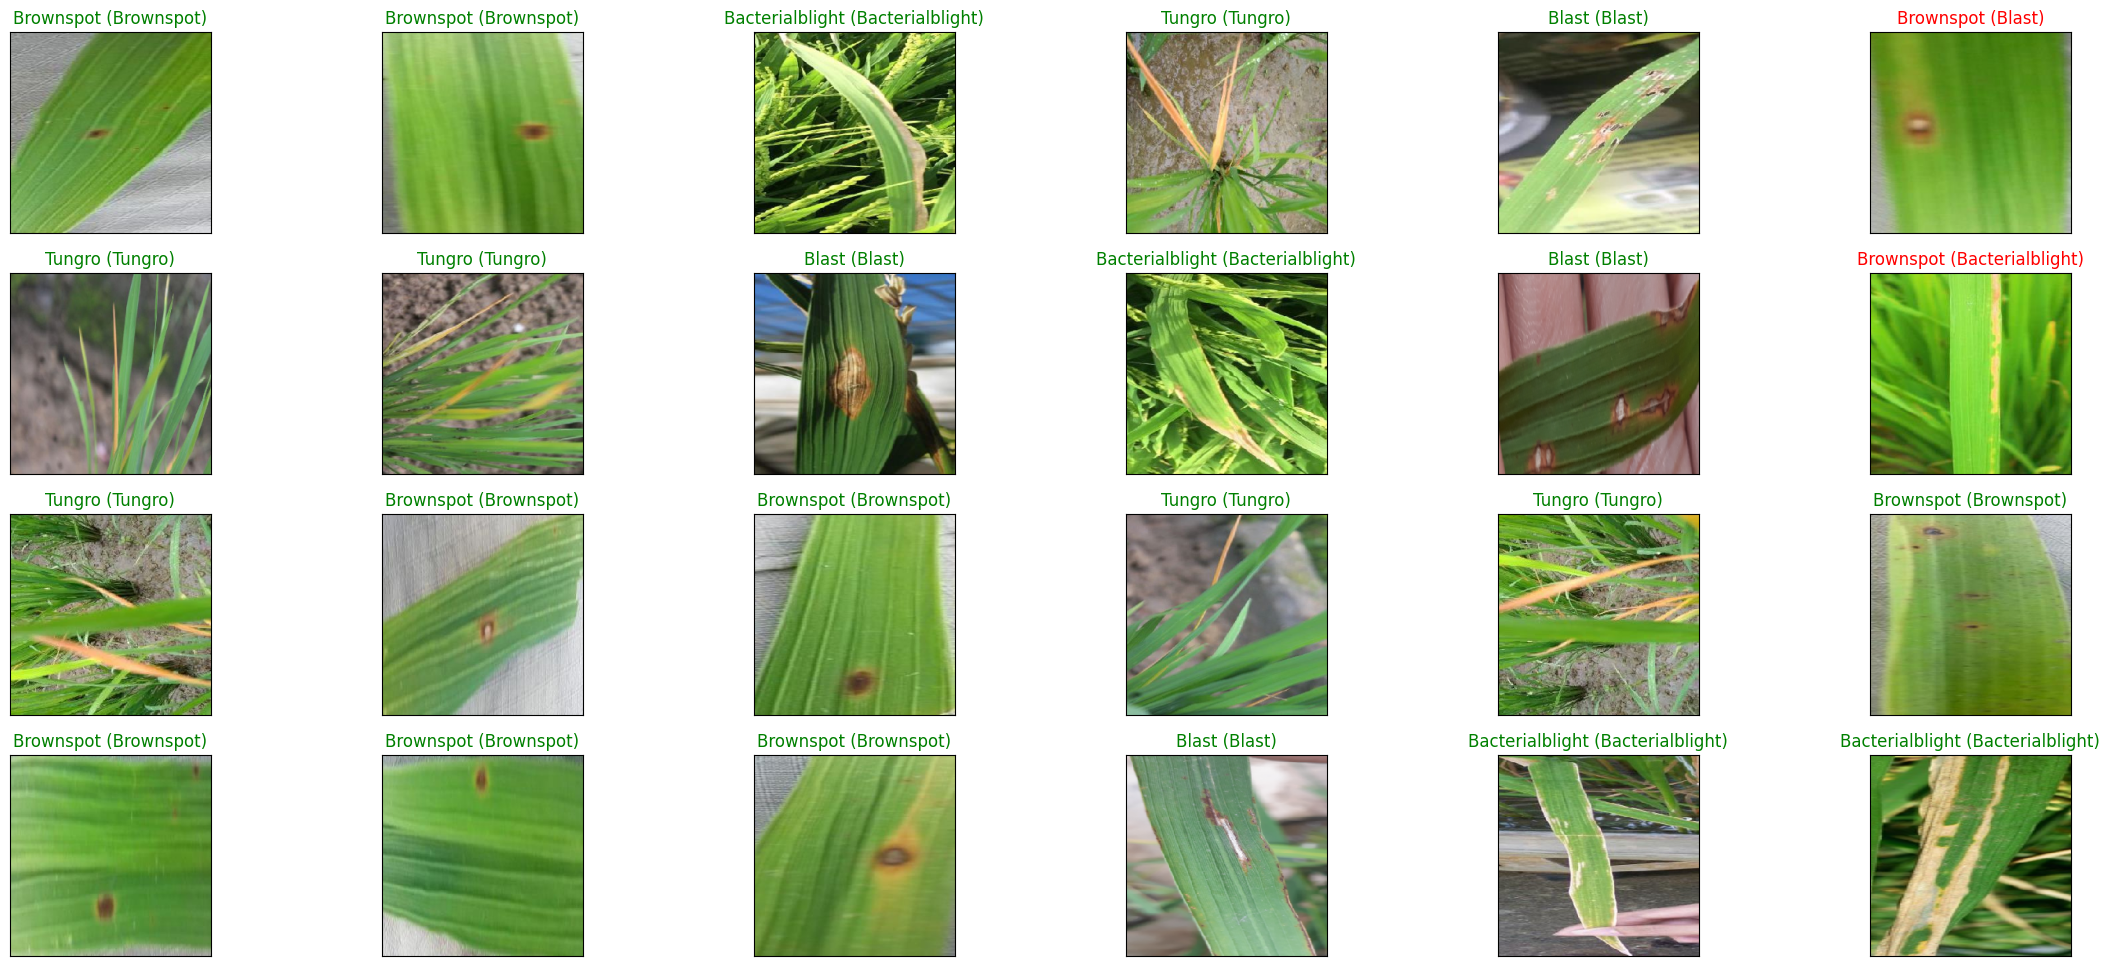

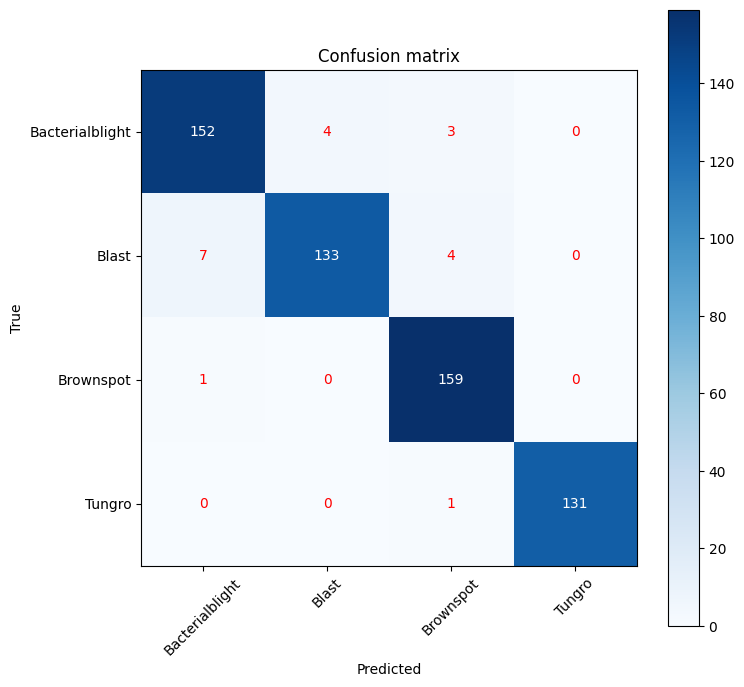

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def extract_data(generator):
    data_list = []
    labels_list = []
    for _ in range(generator.__len__()):
        data, labels = generator.next()
        data_list.append(data)
        labels_list.append(labels)
    x = np.vstack(data_list)
    y = np.vstack(labels_list)
    return x, y

x_train, y_train = extract_data(train_set)
x_test, y_test = extract_data(test_set)

loss = teacher.evaluate(x_test,y_test) 
print("Test Acc: " + str(loss[1]))
preds = teacher.predict(x_test)
y_pred = np.argmax(preds , axis = 1 )
label_dict = {0 : 'Bacterialblight', 1 : 'Blast', 2 : 'Brownspot', 3 : 'Tungro'}

figure = plt.figure(figsize=(28, 12))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))
# Generate classification report
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred)
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

classes = list(label_dict.values())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Print the confusion matrix values on each cell
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='red' if i != j else 'white')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Student Model Architecture & Train & Plotting Curve & Confusion Metrics

In [9]:
student = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D(2,2),  
    layers.Conv2D(16,(3,3),activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(4,activation = 'softmax')
], name='student')
student.summary()
# Clone student for later comparison
student_scratch = tf.keras.models.clone_model(student)

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 16)      9232      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 61504)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                3936

In [10]:
# Train student as done usually using data generator
student_scratch.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

student_history=student_scratch.fit(train_set, epochs=10, validation_data=val_set)
student_scratch.evaluate(test_set)

Epoch 1/10
149/149 [==============================] - 324s 2s/step - loss: 1.3194 - accuracy: 0.4169 - val_loss: 1.2553 - val_accuracy: 0.4578
Epoch 2/10
149/149 [==============================] - 322s 2s/step - loss: 1.2275 - accuracy: 0.4647 - val_loss: 1.2524 - val_accuracy: 0.4696
Epoch 3/10
149/149 [==============================] - 321s 2s/step - loss: 1.1409 - accuracy: 0.5022 - val_loss: 1.0936 - val_accuracy: 0.5422
Epoch 4/10
149/149 [==============================] - 329s 2s/step - loss: 1.0799 - accuracy: 0.5477 - val_loss: 1.0004 - val_accuracy: 0.5760
Epoch 5/10
149/149 [==============================] - 326s 2s/step - loss: 0.9130 - accuracy: 0.6379 - val_loss: 0.7768 - val_accuracy: 0.7010
Epoch 6/10
149/149 [==============================] - 323s 2s/step - loss: 0.7440 - accuracy: 0.7258 - val_loss: 0.7309 - val_accuracy: 0.7568
Epoch 7/10
149/149 [==============================] - 321s 2s/step - loss: 0.6674 - accuracy: 0.7435 - val_loss: 0.5499 - val_accuracy: 0.8057

[0.3592430353164673, 0.8588235378265381]

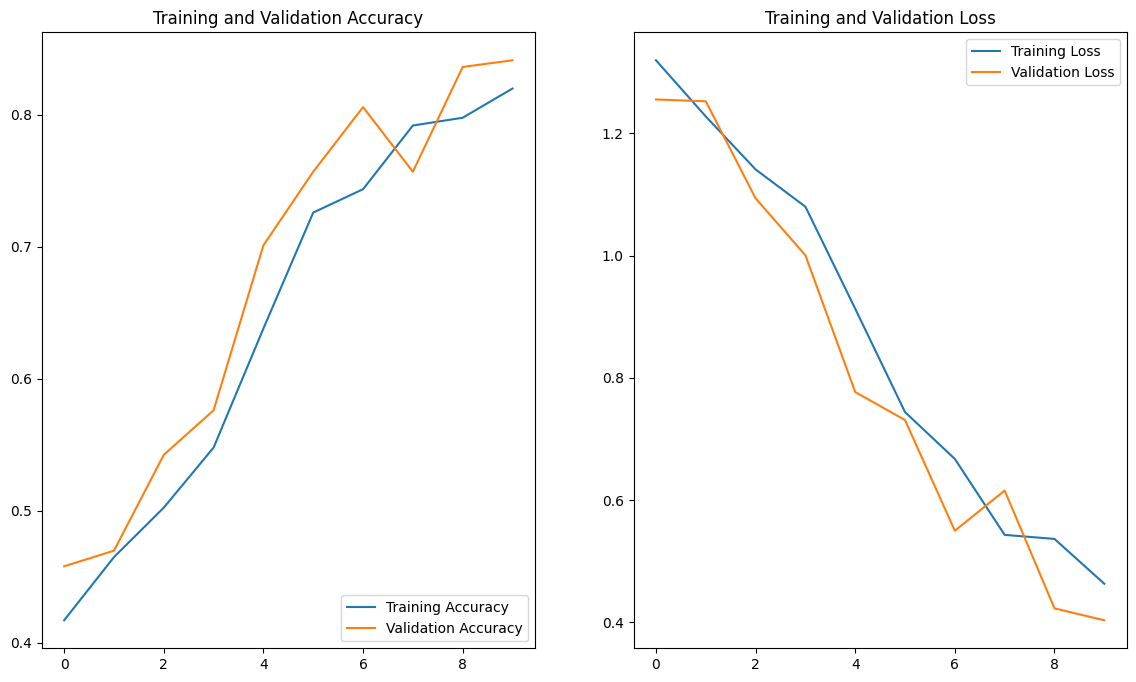

In [11]:
acc = student_history.history['accuracy']
val_acc = student_history.history['val_accuracy']

loss = student_history.history['loss']
val_loss = student_history.history['val_loss']
EPOCHS=10
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

19/19 [==============================] - 33s 2s/step - loss: 0.3592 - accuracy: 0.8588
Test Acc: 0.8588235378265381
19/19 [==============================] - 10s 497ms/step
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       159
           1       0.90      0.69      0.78       144
           2       0.84      0.94      0.89       160
           3       0.89      0.98      0.94       132

    accuracy                           0.86       595
   macro avg       0.86      0.86      0.86       595
weighted avg       0.86      0.86      0.86       595



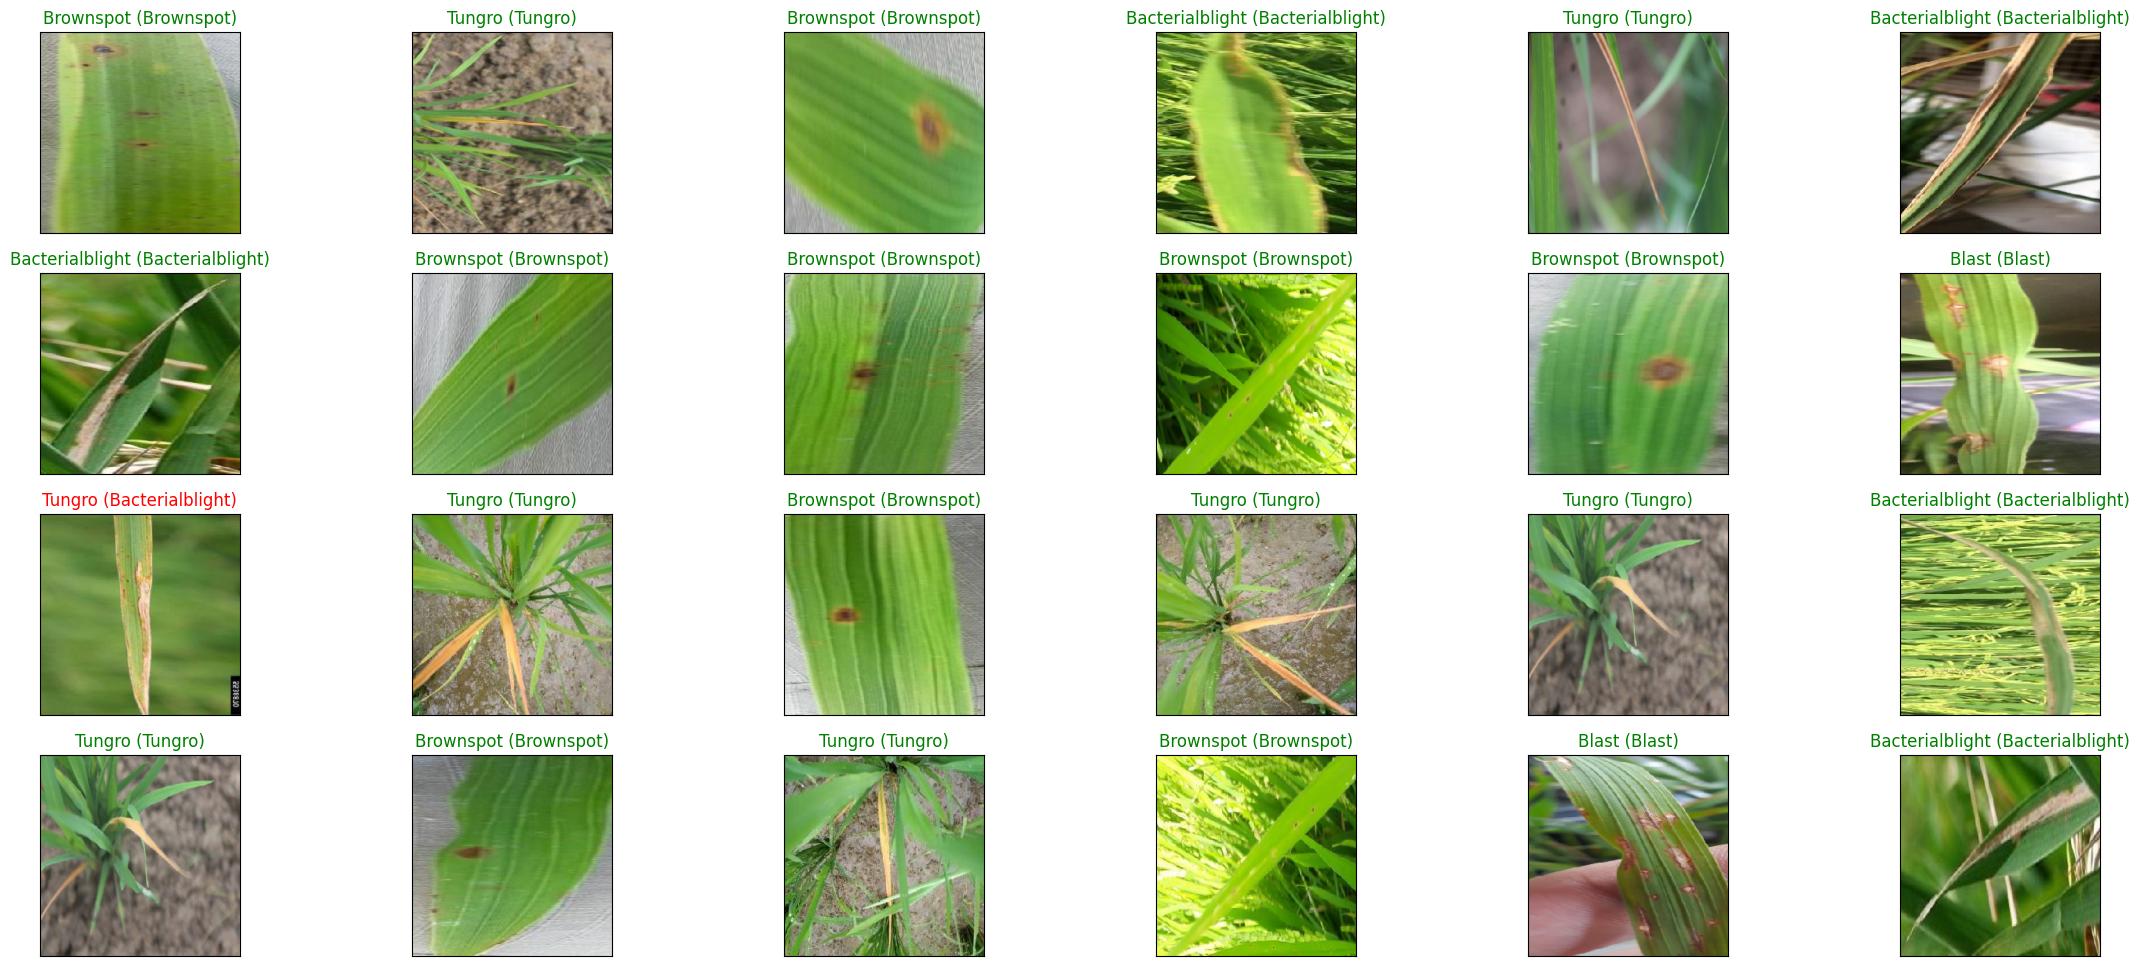

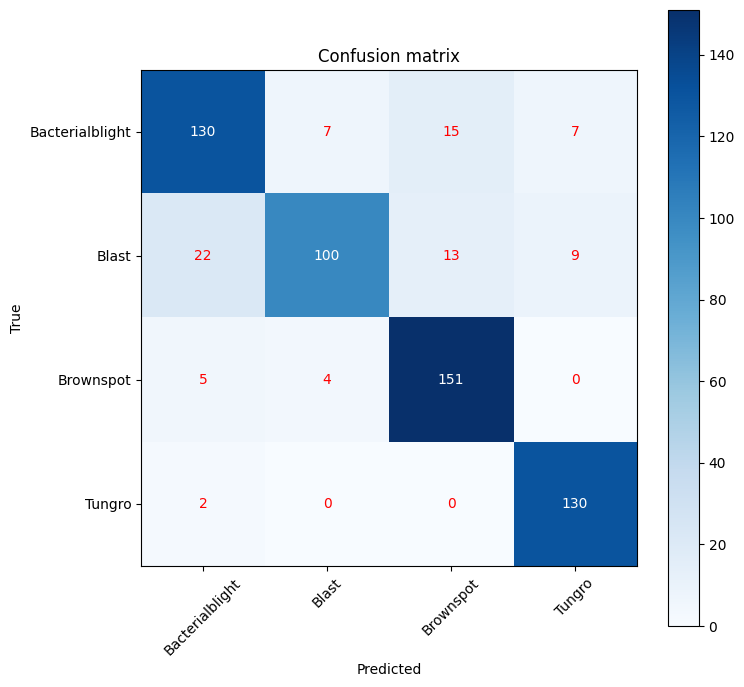

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def extract_data(generator):
    data_list = []
    labels_list = []
    for _ in range(generator.__len__()):
        data, labels = generator.next()
        data_list.append(data)
        labels_list.append(labels)
    x = np.vstack(data_list)
    y = np.vstack(labels_list)
    return x, y

x_train, y_train = extract_data(train_set)
x_test, y_test = extract_data(test_set)

loss = student_scratch.evaluate(x_test,y_test) 
print("Test Acc: " + str(loss[1]))
preds = student_scratch.predict(x_test)
y_pred = np.argmax(preds , axis = 1 )
label_dict = {0 : 'Bacterialblight', 1 : 'Blast', 2 : 'Brownspot', 3 : 'Tungro'}

figure = plt.figure(figsize=(28, 12))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))
# Generate classification report
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred)
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

classes = list(label_dict.values())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Print the confusion matrix values on each cell
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='red' if i != j else 'white')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Now Finally, Distillation

In [13]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer='adam',
    metrics=['accuracy'],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10
)

# Distill teacher to student
distiller_history=distiller.fit(train_set, epochs=20, validation_data=val_set)

# Evaluate student on test dataset
distiller.evaluate(test_set)

Epoch 1/20
149/149 [==============================] - 366s 2s/step - accuracy: 0.4913 - student_loss: 1.2235 - distillation_loss: 0.0708 - val_accuracy: 0.6605 - val_student_loss: 1.5746
Epoch 2/20
149/149 [==============================] - 366s 2s/step - accuracy: 0.6708 - student_loss: 0.8345 - distillation_loss: 0.0490 - val_accuracy: 0.7145 - val_student_loss: 0.6906
Epoch 3/20
149/149 [==============================] - 363s 2s/step - accuracy: 0.7022 - student_loss: 0.7716 - distillation_loss: 0.0437 - val_accuracy: 0.7669 - val_student_loss: 0.5207
Epoch 4/20
149/149 [==============================] - 365s 2s/step - accuracy: 0.7627 - student_loss: 0.6240 - distillation_loss: 0.0332 - val_accuracy: 0.7483 - val_student_loss: 0.5747
Epoch 5/20
149/149 [==============================] - 361s 2s/step - accuracy: 0.7777 - student_loss: 0.5895 - distillation_loss: 0.0315 - val_accuracy: 0.7720 - val_student_loss: 0.5836
Epoch 6/20
149/149 [==============================] - 359s 2s/ste

[0.9260504245758057, 0.11415468901395798]

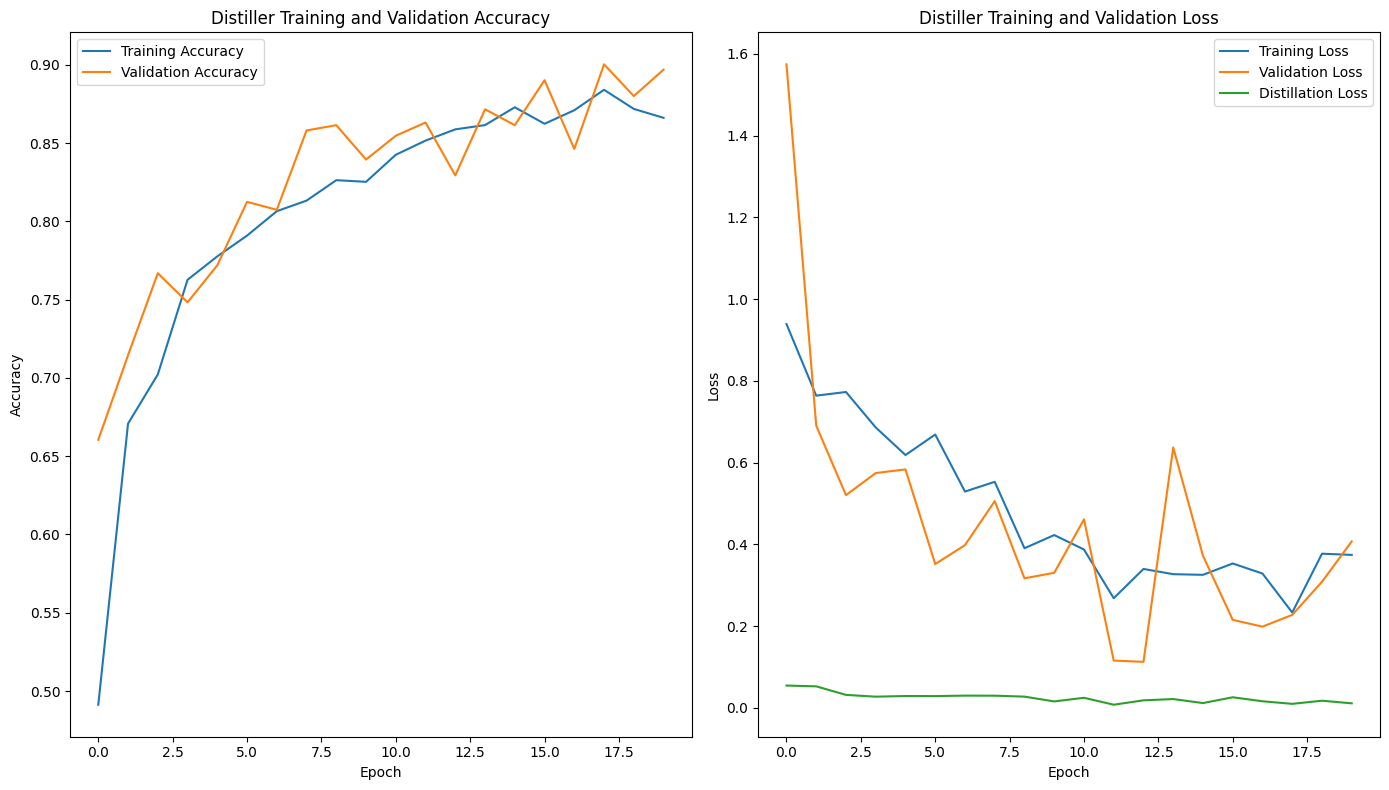

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(distiller_history.history['accuracy'], label='Training Accuracy')
plt.plot(distiller_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Distiller Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(distiller_history.history['student_loss'], label='Training Loss')
plt.plot(distiller_history.history['val_student_loss'], label='Validation Loss')
plt.plot(distiller_history.history['distillation_loss'], label='Distillation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Distiller Training and Validation Loss')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

